In [1]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import catboost
from tqdm import tqdm
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 9)

In [482]:
import glob
import os
file_names = glob.glob('./hackaton_data/*.h5')
dataframes = {
    os.path.basename(fname) : pd.HDFStore(fname)
    for fname in file_names
    if not fname.endswith('KD_050616.h5') and not fname.endswith('KD_040616.h5')
}

In [483]:
def get_timeseries_by_epoch(df, field='signal', common_label=None):
    grouped = df.groupby('epoch')
    tmp = grouped.aggregate(lambda x: tuple(x))[[field]]
    if common_label:
        tmp['label'] = common_label
    return tmp

def get_labels_by_epoch(df, common_label=None):
    tmp = df.loc[:,['epoch','stage']]
    if common_label:
        tmp['label'] = common_label
    return tmp

def get_X_y(dfs):
    X = pd.concat([
        get_timeseries_by_epoch(dfs[df_name]['/eeg_neuroon_cleaned'], 'signal', df_name)
        for df_name in dfs
    ])
    #Xr = pd.concat([
    #    get_timeseries_by_epoch(dfs[df_name]['/eeg_alice_cleaned'], 'signal', df_name)
    #    for df_name in dfs
    #])
    y = pd.concat([
        get_labels_by_epoch(dfs[df_name]['/reference_alice'], df_name)
        for df_name in dfs
    ])
    X.set_index(['label'], inplace=True, append=True)
    #Xr.set_index(['label'], inplace=True, append=True)
    #Xr.rename(columns={'signal': 'signal_alice'}, inplace=True)
    y.set_index(['epoch', 'label'], inplace=True)
    result = pd.concat([X, y], axis=1, join_axes=[X.index])
    return result

In [484]:
result = get_X_y(dataframes)

In [485]:
def has_no_nans(x):
    return not np.isnan(x).any()

data = result[result['signal'].map(has_no_nans)]
#data = data[data['signal_alice'].map(has_no_nans)]

In [486]:
bad = result[~result['signal'].map(has_no_nans)].groupby('label').count().drop(['signal'],axis=1).rename(columns={'stage': 'failed_epochs'})
total = result.groupby('label').count().drop(['signal'],axis=1).rename(columns={'stage': 'total_epochs'})
bad = pd.concat([bad, total], axis=1, join_axes=[bad.index])
bad['percentage_failed'] = bad['failed_epochs'] / bad['total_epochs']

In [487]:
result.head()

,,signal,stage
epoch,label,,
0,LL_190516.h5,"(nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0
1,LL_190516.h5,"(-4251.0, -2823.0, -3082.0, -2703.0, -2617.0, ...",0
2,LL_190516.h5,"(1009.0, 864.0, 543.0, 1376.0, 1126.0, 453.0, ...",0
3,LL_190516.h5,"(-380.0, -202.0, 135.0, -988.0, -723.0, 381.0,...",0
4,LL_190516.h5,"(417.0, 790.0, 288.0, 1102.0, 914.0, 843.0, 14...",0


Text(0.5,1,'Stage: -4')

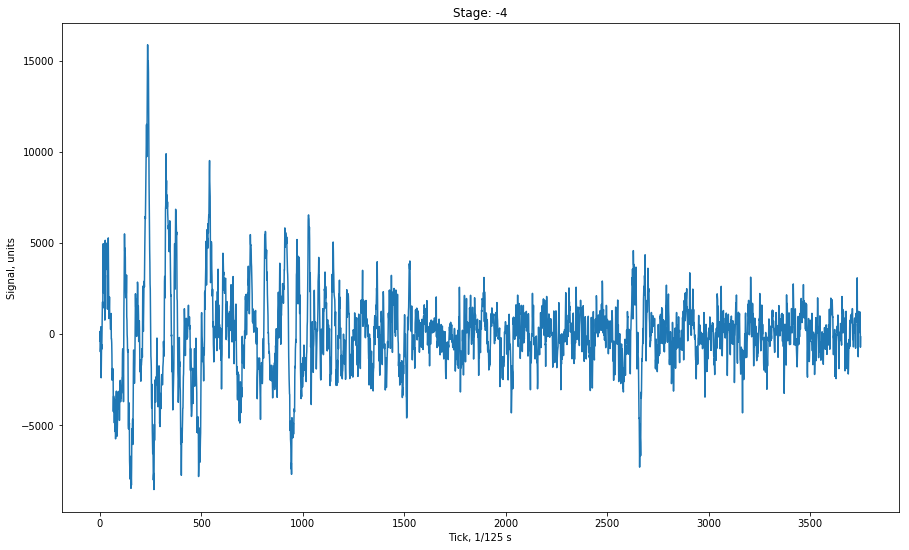

In [491]:
import scipy.signal, scipy.fftpack
x = np.array(data.iloc[1]['signal'])
plt.plot(x)
plt.xlabel('Tick, 1/125 s')
plt.ylabel('Signal, units')
plt.title('Stage: {}'.format(data.iloc[100]['stage']))

In [508]:
from scipy.signal import welch, filtfilt, butter

def filtering(signal,Fs=125):
    Nq=Fs/2
    [b,a] = butter(N=3, Wn=[0.5/Nq, 30./Nq], btype='bandpass')
    return filtfilt(b,a,signal)

def welch_func(x, Fs):
    x = filtering(x)
    N = len(x)
    Nseg = 3
    N_s = N/Nseg
    our_window = np.hamming(N_s)
    our_window /= np.linalg.norm(our_window)
    (F, P) = welch(x, Fs, window=our_window)
    return F, P

def get_power(x, low, high, fs=125):
    F2, P2 = welch_func(x, fs)
    mask = (F2>=low)&(F2<=high)
    power = np.trapz(P2[mask], x=F2[mask])
    return power

freqs = [
    ('Alpha_power', 8, 13),
    ('Alpha2_power', 13, 16),
    ('Beta_power', 13, 30),
    ('Theta_power', 4, 8),
    ('Mu_power', 7.5, 12.5),
    ('Delta_power', 0.5, 4),
    ('SMR_power', 12.5, 15.5),
    ('K_complex_power', 0.5, 1.5),
    ]

for freq in freqs:
    field_name, low, high = freq
    data[field_name] = data['signal'].map(lambda x: get_power(x, low, high))

# data['All_power'] = data[[freq[0] for freq in freqs]].sum(axis=1)

for freq in freqs:
    field_name, _, _ = freq
    data[field_name+'_log'] = np.log(data[field_name])

/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [509]:
data['Mean'] = data['signal'].map(np.mean)
data['Std'] = data['signal'].map(np.std)
data['Skew'] = data['signal'].map(scipy.stats.skew)
data['Kurtosis'] = data['signal'].map(scipy.stats.kurtosis)

/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

S

In [510]:
def Hjorth_a(x):
    x = np.array(x)
    var_x = np.mean(x**2)
    return var_x

def Hjorth_m(x):
    x = np.array(x)
    dx = np.diff(x)
    var_x = np.mean(x**2)
    var_dx = np.mean(dx**2)
    return np.sqrt(var_dx/var_x)

def Hjorth_c(x):
    x = np.array(x)
    dx = np.diff(x)
    d2x = np.diff(x,2)
    
    var_x = np.mean(x**2)
    var_dx = np.mean(dx**2)
    var_d2x = np.mean(d2x**2)

    morbidity = np.sqrt(var_dx/var_x)
    complexity = np.sqrt(var_d2x/var_dx) / morbidity
    return complexity

data['Hjorth_activity'] = data['signal'].map(Hjorth_a)
data['Hjorth_mobility'] = data['signal'].map(Hjorth_m)
data['Hjorth_complexity'] = data['signal'].map(Hjorth_c)

/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas

In [511]:
def sef(x, f=90, fs=125.0):
    x = np.array(x)
    tfreq = 40  # to speed up calculations, we look at the range below 40 Hz, because most power is below this frequency
    topfreq = int(round(x.shape[0] / fs * tfreq)) + 1 # index corresponding to topFreq in FFT
    
    D = np.absolute(np.fft.rfft(x,))
    D[0] = 0  # set the DC component to zero
    D /= D.sum() # Normalize each channel
    
    A = np.cumsum(D[:topfreq]) # cumulative power at different freqs in each channel
    B = A - (A.max() * f)  # shift the baseline (see next line)
    
    spedge = np.min(np.abs(B)) # index of lowest value by channel (which corresponds to SEF)
    spedge = (spedge - 1) / (topfreq - 1) * tfreq
    return spedge


for i in [50, 90]:
    data['SEF{}'.format(i)] = data['signal'].map(lambda x: sef(x, i))
    #data.drop(['SEF{}'.format(i)], axis=1, inplace=True)
#data.drop(['SEF90'], axis=1, inplace=True)

/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [512]:
data.head()

,,signal,stage,Alpha_power,Alpha2_power,Beta_power,Theta_power,Mu_power,Delta_power,SMR_power,K_complex_power,...,K_complex_power_log,Mean,Std,Skew,Kurtosis,Hjorth_activity,Hjorth_mobility,Hjorth_complexity,SEF50,SEF90
epoch,label,,,,,,,,,,,,,,,,,,,,,
2,LL_190516.h5,"(1009.0, 864.0, 543.0, 1376.0, 1126.0, 453.0, ...",0,306558.627046,106887.338817,251852.018589,506670.891193,333081.542051,5.406833e+06,104260.658201,3.014231e+06,...,14.918855,-28.145867,2625.087601,0.254180,1.529566,6.891877e+06,0.359225,3.809057,1.433683,2.631248
3,LL_190516.h5,"(-380.0, -202.0, 135.0, -988.0, -723.0, 381.0,...",0,185638.718881,79938.630083,176796.347172,392268.369853,206778.123274,2.549965e+06,86869.856244,1.104560e+06,...,13.914957,5.272800,2239.202548,0.709946,5.797621,5.014056e+06,0.356931,3.822558,1.440670,2.643939
4,LL_190516.h5,"(417.0, 790.0, 288.0, 1102.0, 914.0, 843.0, 14...",0,103169.065027,48880.364535,129925.689624,149012.656590,103433.220856,6.510533e+05,52639.451073,3.889810e+05,...,12.871286,5.617333,1164.997867,0.574339,2.790268,1.357252e+06,0.578683,2.445529,1.390463,2.552745
5,LL_190516.h5,"(-284.0, -679.0, -878.0, -636.0, -537.0, -219....",0,89208.115609,28627.651109,89406.120660,108440.670419,91067.583536,5.661927e+05,31864.180064,3.210304e+05,...,12.679291,-22.637600,1043.413060,0.256080,0.451432,1.089223e+06,0.562842,2.526081,1.385738,2.544163
6,LL_190516.h5,"(-4283.0, -3493.0, -4190.0, -3646.0, -2984.0, ...",0,203352.501706,51343.966716,134894.132909,517980.294749,261063.772693,2.092081e+06,56334.419789,8.497351e+05,...,13.652680,-8.660533,1761.893565,-0.357830,1.238478,3.104344e+06,0.382883,3.416092,1.438653,2.640275


In [522]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [523]:
import sklearn.metrics

def remove_jitter(x):
    return scipy.signal.medfilt(x, (7,))

def run_classifier(cls):
    acc_of_fail = []
    X = data.drop(['signal', 'stage'], axis=1)
    y = np.abs(data['stage'])
    groups = data.index.get_level_values('label').tolist()

    accs_test = []
    cm = None
    for train_index, test_index  in LeaveOneGroupOut().split(X=X, y=y, groups=groups):
        #if bad.loc[label]['percentage_failed']
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        label = groups[test_index[0]]

        cls.fit(X_train, y_train)
        p = cls.predict(X_test)
        p_t = cls.predict(X_train)
        
        p = remove_jitter(p)
        p_t = remove_jitter(p_t)
        
        acc_test = accuracy_score(y_test, p)
        accs_test.append(acc_test)
        acc_train = accuracy_score(y_train, p_t)
        
        print('{}, {}, {}'.format(label, acc_test, acc_train))
        acc_of_fail.append((bad.loc[label]['percentage_failed'], acc_test))
        if cm is None:
            cm = confusion_matrix(y_test, p)
        else:
            cm += confusion_matrix(y_test, p)
            
        plt.figure(figsize=(5,4))
        plt.title('Testing on {}, accuracy {:.2f}'.format(label, acc_test))
        #plt.fill_between(np.arange(len(y_test)), y1=0, y2=-y_test.values)
        ref = result[result.index.get_level_values('label')==label]
        ref_ind = ref.index.get_level_values('epoch')
        
        our = data[data.index.get_level_values('label')==label]
        our_ind =our.index.get_level_values('epoch')

        plt.plot(ref_ind, ref['stage'].values)
        plt.plot(our_ind, -p, alpha=0.7)
        plt.gca().set_yticks([-4, -3, -1, 0])
        plt.gca().set_yticklabels(['Deep', 'Light', 'REM', 'Awake'])
        plt.xlabel('Epoch')
        plt.savefig('Timeline_{}.png'.format(label), dpi=600)
        #p = cls.predict(X_test)
        #print(sklearn.metrics.classification_report(y_test, p, target_names=['Awake', 'REM', 'S3', 'S4']))

    print('Test accuracy: {} +- {}'.format(np.mean(accs_test), np.std(accs_test)))
    plt.clf()
    plot_confusion_matrix(cm, ['Awake', 'REM', 'Light', 'Deep'])
    plt.savefig('confusion.png', dpi=600)
    
    plt.figure(figsize=(5,4))
    acc_of_fail = np.array(acc_of_fail)
    plt.figure(figsize=(5,4))
    plt.scatter(acc_of_fail[:,0]*100, acc_of_fail[:,1], s=30)
    plt.xlabel('Saturated segments in recording, %')
    plt.ylabel('Accuracy')
    plt.savefig('signal.png', dpi=600)
    return cls

AP_210516.h5, 0.6094986807387863, 0.8054191363251482
AP_230516.h5, 0.7795918367346939, 0.7982456140350878
BK_090616.h5, 0.7233009708737864, 0.7910669975186104
GD_030516.h5, 0.7548872180451128, 0.7975991997332444
GD_300416.h5, 0.7402135231316725, 0.8089347079037801
KD_060616.h5, 0.7951807228915663, 0.7948043406774088
LL_190516.h5, 0.7403598971722365, 0.7979609175870858
TG_180616.h5, 0.8084378563283923, 0.7910473556861389
TG_190616.h5, 0.7970297029702971, 0.7936806148590948
Test accuracy: 0.7498333787651715 +- 0.05696933985830052
Confusion matrix, without normalization
[[  19  145  279   13]
 [  16 1139  316   36]
 [  23  262 3175  231]
 [   0    1  342  666]]


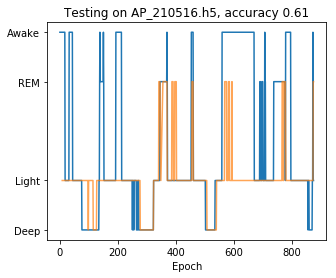

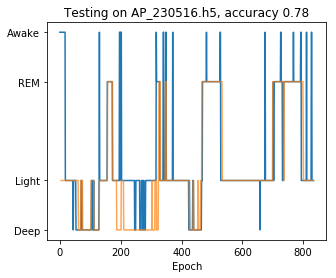

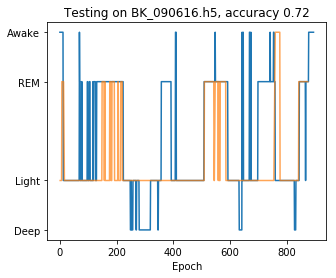

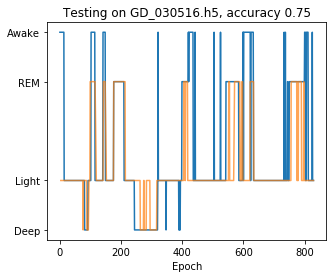

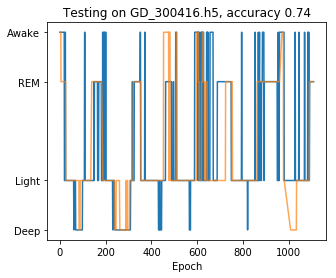

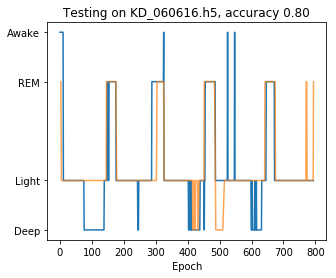

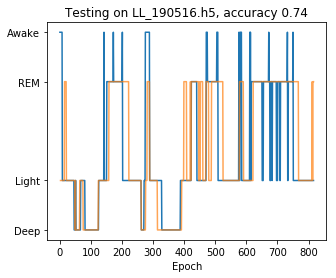

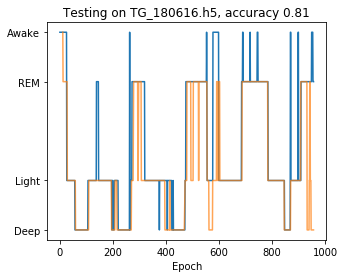

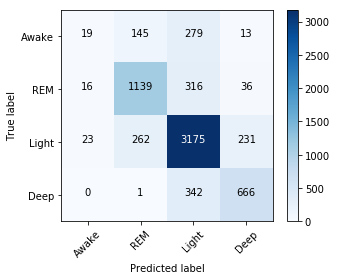

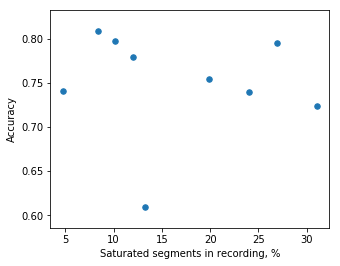

In [524]:
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import make_pipeline

cls = make_pipeline(StandardScaler(), LinearSVC(C=1, penalty='l2', dual=False))
cls = run_classifier(cls)

Acc test: 0.5870712401055409, Acc train: 0.736155800169348
Acc test: 0.6503401360544218, Acc train: 0.7240215924426451
Acc test: 0.598705501618123, Acc train: 0.7291976840363937
Acc test: 0.5894736842105263, Acc train: 0.7205735245081694
Acc test: 0.638196915776987, Acc train: 0.7348797250859107
Acc test: 0.7624784853700516, Acc train: 0.7097994080894443
Acc test: 0.7223650385604113, Acc train: 0.7209855564995752
Acc test: 0.7879133409350056, Acc train: 0.7091254752851711
Acc test: 0.6868811881188119, Acc train: 0.7214346712211784
Test accuracy: 0.6692695034166533 +- 0.07096212921414284


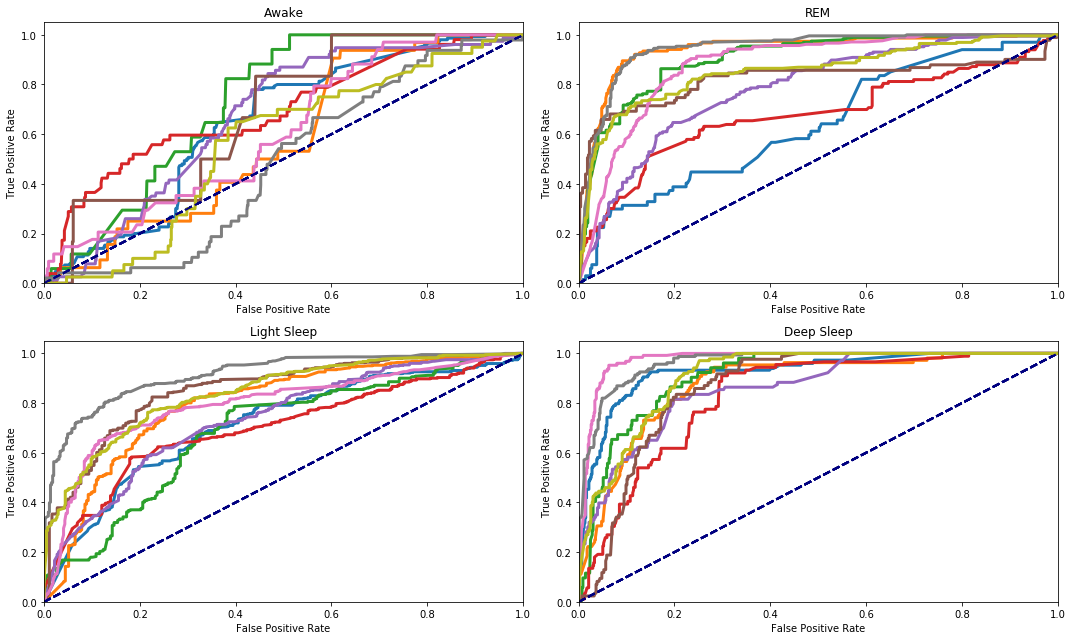

In [531]:
from scipy import interp
from sklearn.metrics import roc_curve, auc

X = data.drop(['signal', 'stage'], axis=1)
y = np.abs(data['stage'])
groups = data.index.get_level_values('label').tolist()
a=0
stage_1_fpr, stage_2_fpr, stage_3_fpr, stage_4_fpr = [],[],[],[]
stage_1_tpr, stage_2_tpr, stage_3_tpr, stage_4_tpr = [],[],[],[]
aucs = []
accs_test = []

for q, (train_index, test_index)  in enumerate(LeaveOneGroupOut().split(X=X, y=y, groups=groups)):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    cls = RandomForestClassifier(max_depth=4).fit(X_train, y_train)

    probas_ = cls.fit(X_train, y_train).predict_proba(X_test)
    # Compute ROC curve and area the curve
    a, b= [] , []
    for i, stage in enumerate([0,1,3,4]):
        fpr, tpr, thresholds = roc_curve(y_test==stage, probas_[:, i])
        a.append(fpr)
        b.append(tpr)

    stage_1_fpr.append(a[0])
    stage_2_fpr.append(a[1])
    stage_3_fpr.append(a[2])
    stage_4_fpr.append(a[3])

    stage_1_tpr.append(b[0])
    stage_2_tpr.append(b[1])
    stage_3_tpr.append(b[2])
    stage_4_tpr.append(b[3])
   
    acc_test = accuracy_score(y_test, cls.predict(X_test))
    accs_test.append(acc_test)
    acc_train = accuracy_score(y_train, cls.predict(X_train))
    print('Acc test: {}, Acc train: {}'.format(acc_test, acc_train))

print('Test accuracy: {} +- {}'.format(np.mean(accs_test), np.std(accs_test)))
our = data[data.index.get_level_values('label')=='TG_180616.h5']
our_ind = our.index.get_level_values('epoch')

de=[[stage_1_fpr,stage_1_tpr,"Awake"],
    [stage_2_fpr,stage_2_tpr,"REM"],
    [stage_3_fpr,stage_3_tpr,"Light Sleep"],
    [stage_4_fpr,stage_4_tpr,"Deep Sleep"]]

for j in range(4):
    plt.subplot(2,2,j+1)
    for i in range(len(de[0][0])):
        fpr, tpr = de[j][0][i], de[j][1][i]
        plt.plot(fpr, tpr, lw=3)#, alpha=0.3,
        plt.title(str(de[j][2]))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.tight_layout()

plt.show()

In [434]:
our =data[data.index.get_level_values('label')=='TG_180616.h5']
our_ind =our.index.get_level_values('epoch')

ori = result[result.index.get_level_values('label')=='TG_180616.h5']
ori_ind =ori.index.get_level_values('epoch')

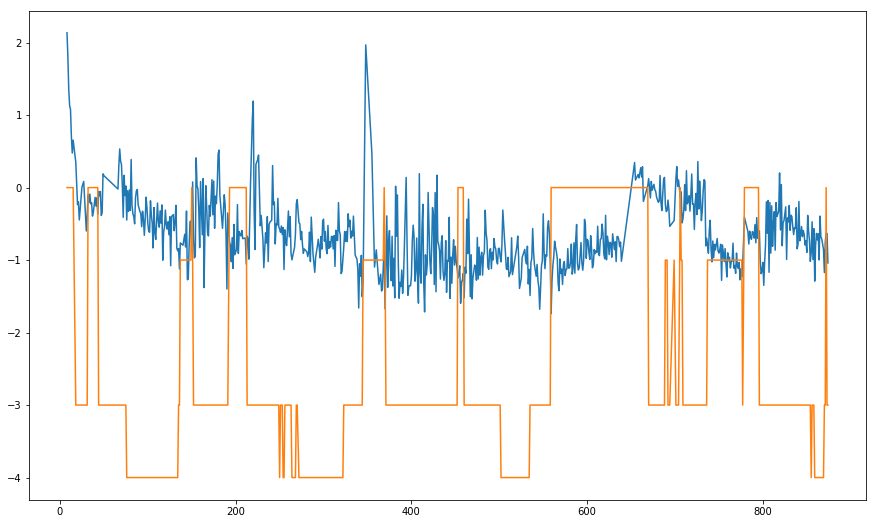

In [525]:
df1 = data[data.index.get_level_values('label')=='AP_210516.h5']
xax = df1.index.get_level_values('epoch')
plt.plot(xax, df1['Alpha_power_log']-12)
plt.plot(xax, df1['stage'])

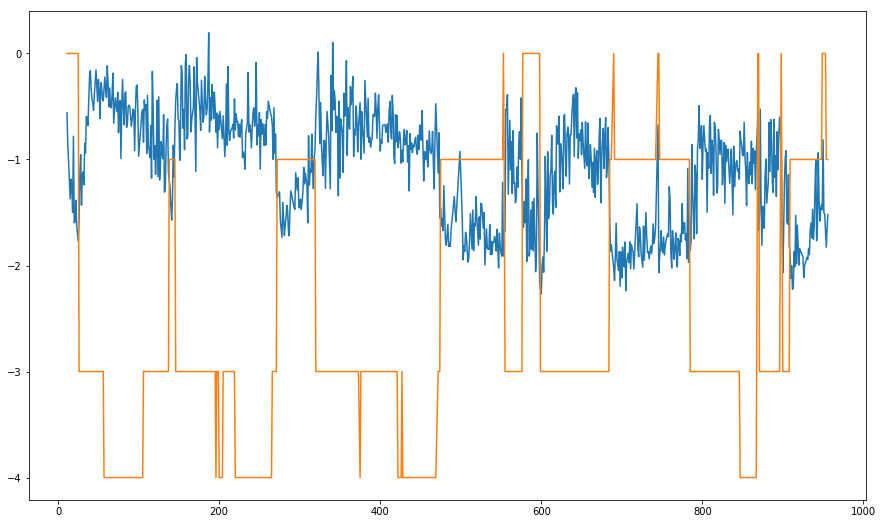

In [526]:
df1 = data[data.index.get_level_values('label')=='TG_180616.h5']
plt.plot(df1.index.get_level_values('epoch'), df1['Alpha_power_log']-12)
plt.plot(df1.index.get_level_values('epoch'), df1['stage'])

AP_210516.h5, 0.5804749340369393, 0.7214225232853514
AP_230516.h5, 0.7482993197278912, 0.7096828609986505
BK_090616.h5, 0.598705501618123, 0.7341604631927212
GD_030516.h5, 0.6120300751879699, 0.7210736912304101
GD_300416.h5, 0.5848161328588375, 0.7238831615120275
KD_060616.h5, 0.8554216867469879, 0.7186780664255179
LL_190516.h5, 0.7750642673521851, 0.7043330501274426
TG_180616.h5, 0.8198403648802737, 0.7129277566539924
TG_190616.h5, 0.6831683168316832, 0.7197267292912041
Test accuracy: 0.6953133999156544 +- 0.10117287601881905
Confusion matrix, without normalization
[[   0   63  388    5]
 [   0  725  763   19]
 [   0  125 3401  165]
 [   0    1  503  505]]


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

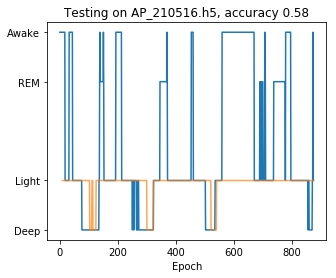

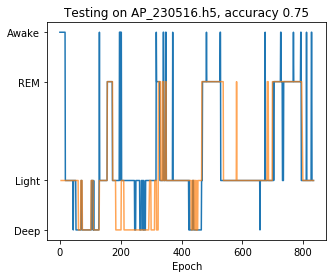

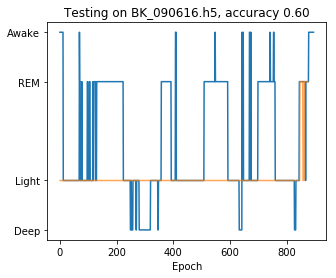

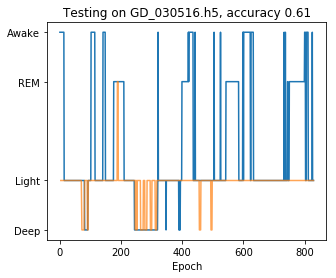

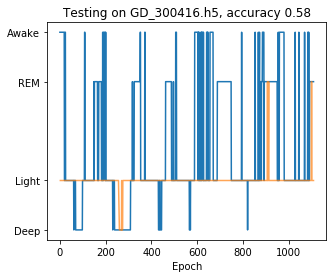

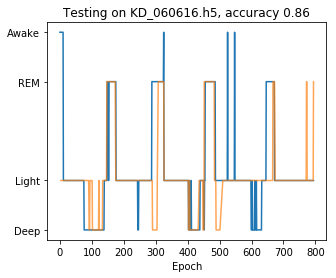

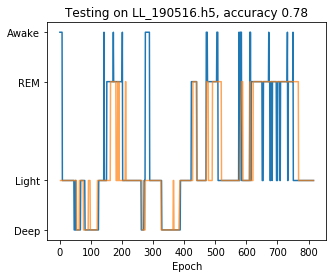

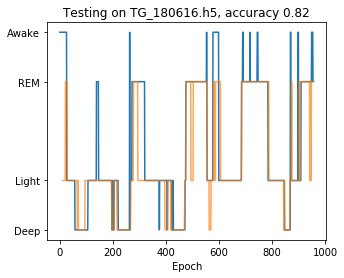

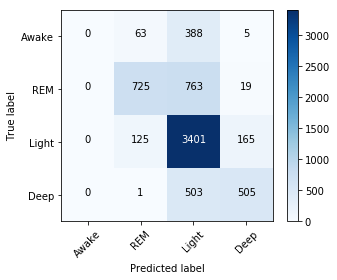

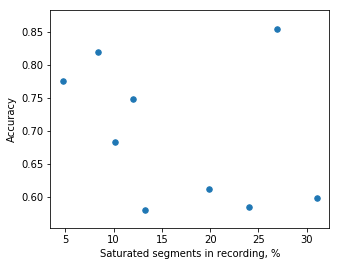

In [527]:
from sklearn.ensemble import RandomForestClassifier
cls = RandomForestClassifier(n_estimators=20, max_depth=3)
run_classifier(cls)

In [296]:
X.head()

,,Alpha_power,Alpha2_power,Beta_power,Theta_power,Delta_power,K_complex_power,Mean,Std,Skew,Kurtosis,Hjorth_activity,Hjorth_mobility,Hjorth_complexity,Alpha_power_log,Alpha2_power_log,Beta_power_log,Theta_power_log,Delta_power_log,K_complex_power_log
epoch,label,,,,,,,,,,,,,,,,,,,
2,LL_190516.h5,306769.301555,107582.260746,286006.246026,506647.973140,5.640379e+06,3.247275e+06,-28.145867,2625.087601,0.254180,1.529566,6.891877e+06,0.359225,3.809057,12.633851,11.586011,12.563769,13.135572,15.545462,14.993327
3,LL_190516.h5,185759.848665,80413.322924,202162.364974,392273.713314,2.673335e+06,1.227616e+06,5.272800,2239.202548,0.709946,5.797621,5.014056e+06,0.356931,3.822558,12.132210,11.294935,12.216826,12.879715,14.798837,14.020585
4,LL_190516.h5,103247.867768,49195.778401,151759.567554,149010.360396,6.907016e+05,4.286218e+05,5.617333,1164.997867,0.574339,2.790268,1.357252e+06,0.578683,2.445529,11.544888,10.803563,11.930053,11.911771,13.445463,12.968330
5,LL_190516.h5,89280.091032,28801.777815,106593.400539,108452.003819,5.912435e+05,3.458951e+05,-22.637600,1043.413060,0.256080,0.451432,1.089223e+06,0.562842,2.526081,11.399534,10.268192,11.576777,11.594063,13.289983,12.753891
6,LL_190516.h5,203425.764684,51679.225843,155371.440855,517938.704604,2.188552e+06,9.460194e+05,-8.660533,1761.893565,-0.357830,1.238478,3.104344e+06,0.382883,3.416092,12.223056,10.852811,11.953574,13.157612,14.598751,13.760018


In [528]:
Below are some temporary thingies

SyntaxError: invalid syntax (<ipython-input-528-7463e6684ad3>, line 1)

(1000, 2000)

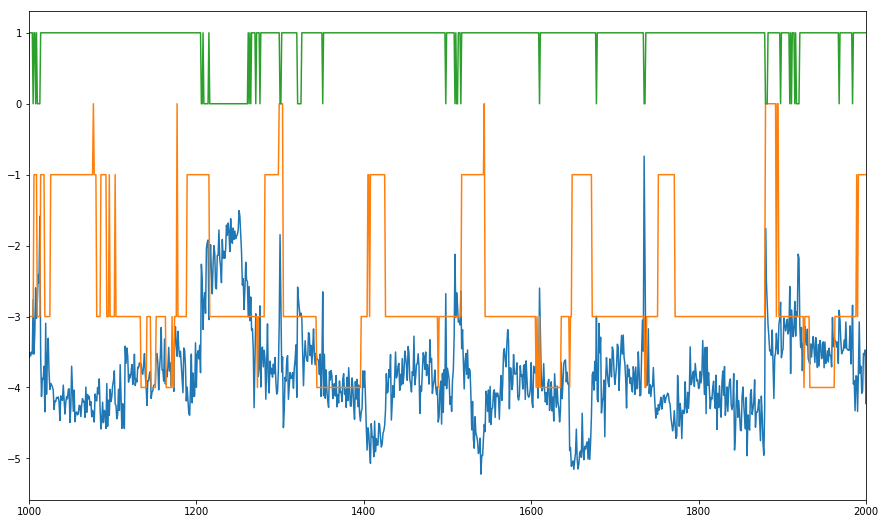

In [300]:
plt.plot(X['Alpha_power_log'].values-15)
plt.plot(-y.values)
plt.plot(X['Alpha_power_log'].values<12)
plt.xlim([1000,2000])

(1000, 2000)

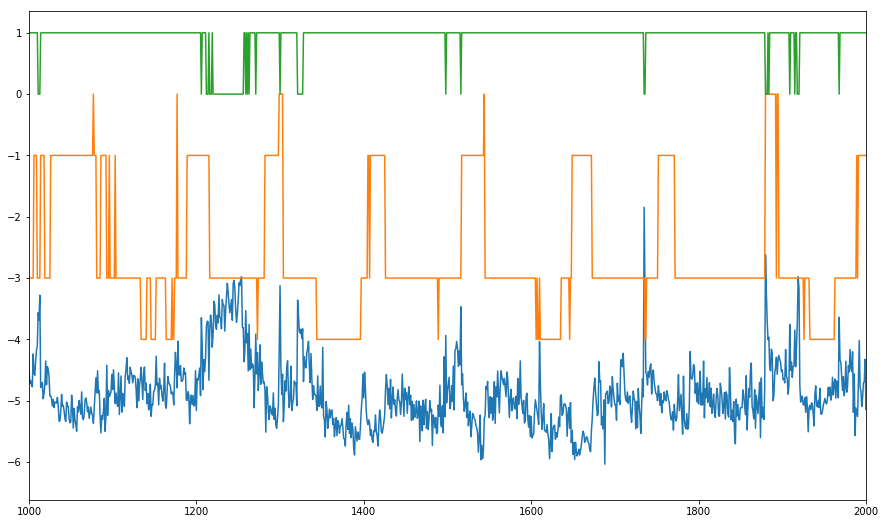

In [257]:
plt.plot(X['Alpha2_power_log'].values-15)
plt.plot(-y.values)
plt.plot(X['Alpha2_power_log'].values<11)
plt.xlim([1000,2000])

In [227]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(5, sparse=False)
spectrogram = np.array([scipy.signal.spectrogram(np.array(x), fs=125, nperseg=128, noverlap=64)[2] for x in data['signal']])
spectrogram = spectrogram.values.reshape((*spectrogram.shape, 1))
spectrogram = np.log(spectrogram) / 20 # Shitty scaling
y_ohe = np.abs(data['stage']).values
y_ohe = ohe.fit_transform(y.reshape(y_ohe.shape[0], 1))
groups = data.index.get_level_values('label').tolist()
print(spectrogram.shape, y_ohe.shape)

(7184, 65, 57, 1) (7184, 5)


/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


In [228]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import keras.losses

def build_model():
    batch_size = 128
    num_classes = 5
    epochs = 30

    model = Sequential()
    model.add(Conv2D(16, (3, 3), padding='valid', input_shape=(65, 57, 1)))
    model.add(Activation('tanh'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    #model.add(Conv2D(8, (2, 2), padding='valid', input_shape=X.shape[1:]))
    #model.add(Activation('tanh'))
    #model.add(MaxPooling2D(pool_size=(1, 2)))

    model.add(Flatten())
    #model.add(Dense(64))
    #model.add(Activation('tanh'))
    #model.add(Dropout(0.4))


    model.add(Dense(num_classes))
    model.add(Activation('softmax'))

    model.save_weights('/tmp/model.h5')

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

accs_test = []
for train_index, test_index  in LeaveOneGroupOut().split(X=X, y=y, groups=groups):
    x_train, x_test = spectrogram[train_index,:], spectrogram[test_index,:]
    y_train, y_test = y_ohe[train_index], y_ohe[test_index]
    model = build_model()
    
    model.fit(x_train, y=y_train,
              batch_size=batch_size,
              epochs=epochs, shuffle=True, validation_split=0.1,
              verbose=2)

    print(y_test.shape, model.predict(x_test).shape)
    acc_test = accuracy_score(y_test, model.predict(x_test).round())
    accs_test.append(acc_test)
    acc_train = accuracy_score(y_train, model.predict(x_train).round())
    print('Acc test: {}, Acc train: {}'.format(acc_test, acc_train))

print('Test accuracy: {} +- {}'.format(np.mean(accs_test), np.std(accs_test)))

Train on 5783 samples, validate on 643 samples
Epoch 1/30
 - 1s - loss: 1.1353 - acc: 0.5265 - val_loss: 0.9531 - val_acc: 0.6299
Epoch 2/30
 - 0s - loss: 1.0457 - acc: 0.5485 - val_loss: 0.9025 - val_acc: 0.6299
Epoch 3/30
 - 0s - loss: 0.9785 - acc: 0.5622 - val_loss: 0.8773 - val_acc: 0.6376
Epoch 4/30
 - 0s - loss: 0.9202 - acc: 0.5876 - val_loss: 0.8110 - val_acc: 0.6423
Epoch 5/30
 - 0s - loss: 0.8684 - acc: 0.6308 - val_loss: 0.7875 - val_acc: 0.6936
Epoch 6/30
 - 0s - loss: 0.8259 - acc: 0.6562 - val_loss: 0.7096 - val_acc: 0.7418
Epoch 7/30
 - 0s - loss: 0.8261 - acc: 0.6502 - val_loss: 0.7058 - val_acc: 0.6921
Epoch 8/30
 - 0s - loss: 0.7711 - acc: 0.7022 - val_loss: 0.6701 - val_acc: 0.7854
Epoch 9/30
 - 0s - loss: 0.7462 - acc: 0.7114 - val_loss: 0.6583 - val_acc: 0.8040
Epoch 10/30
 - 0s - loss: 0.7193 - acc: 0.7238 - val_loss: 0.6692 - val_acc: 0.7574
Epoch 11/30
 - 0s - loss: 0.7022 - acc: 0.7299 - val_loss: 0.6364 - val_acc: 0.7107
Epoch 12/30
 - 0s - loss: 0.6834 - acc

Epoch 4/30
 - 0s - loss: 0.9737 - acc: 0.5575 - val_loss: 0.8900 - val_acc: 0.6074
Epoch 5/30
 - 0s - loss: 0.9363 - acc: 0.5903 - val_loss: 0.7884 - val_acc: 0.6396
Epoch 6/30
 - 0s - loss: 0.8662 - acc: 0.6335 - val_loss: 0.7767 - val_acc: 0.7193
Epoch 7/30
 - 0s - loss: 0.8282 - acc: 0.6681 - val_loss: 0.7129 - val_acc: 0.7255
Epoch 8/30
 - 0s - loss: 0.8089 - acc: 0.6668 - val_loss: 0.6659 - val_acc: 0.7531
Epoch 9/30
 - 0s - loss: 0.7962 - acc: 0.6731 - val_loss: 0.6397 - val_acc: 0.6979
Epoch 10/30
 - 0s - loss: 0.7670 - acc: 0.6978 - val_loss: 0.6199 - val_acc: 0.7485
Epoch 11/30
 - 0s - loss: 0.7412 - acc: 0.7160 - val_loss: 0.6155 - val_acc: 0.7945
Epoch 12/30
 - 0s - loss: 0.7202 - acc: 0.7079 - val_loss: 0.5913 - val_acc: 0.7929
Epoch 13/30
 - 0s - loss: 0.7149 - acc: 0.7210 - val_loss: 0.5979 - val_acc: 0.7669
Epoch 14/30
 - 0s - loss: 0.6808 - acc: 0.7362 - val_loss: 0.5844 - val_acc: 0.7837
Epoch 15/30
 - 0s - loss: 0.6704 - acc: 0.7440 - val_loss: 0.5697 - val_acc: 0.762

Epoch 8/30
 - 0s - loss: 0.8979 - acc: 0.6245 - val_loss: 0.7073 - val_acc: 0.7776
Epoch 9/30
 - 0s - loss: 0.8357 - acc: 0.6738 - val_loss: 0.6755 - val_acc: 0.6596
Epoch 10/30
 - 0s - loss: 0.8048 - acc: 0.6878 - val_loss: 0.7026 - val_acc: 0.7837
Epoch 11/30
 - 0s - loss: 0.8026 - acc: 0.6767 - val_loss: 0.6280 - val_acc: 0.7292
Epoch 12/30
 - 0s - loss: 0.7802 - acc: 0.6806 - val_loss: 0.7554 - val_acc: 0.7247
Epoch 13/30
 - 0s - loss: 0.7530 - acc: 0.7030 - val_loss: 0.6149 - val_acc: 0.7927
Epoch 14/30
 - 0s - loss: 0.7381 - acc: 0.7075 - val_loss: 0.6416 - val_acc: 0.7443
Epoch 15/30
 - 0s - loss: 0.7365 - acc: 0.7072 - val_loss: 0.6237 - val_acc: 0.7912
Epoch 16/30
 - 0s - loss: 0.6933 - acc: 0.7319 - val_loss: 0.5632 - val_acc: 0.7731
Epoch 17/30
 - 0s - loss: 0.6794 - acc: 0.7415 - val_loss: 0.6410 - val_acc: 0.7685
Epoch 18/30
 - 0s - loss: 0.6792 - acc: 0.7388 - val_loss: 0.5462 - val_acc: 0.8079
Epoch 19/30
 - 0s - loss: 0.6439 - acc: 0.7541 - val_loss: 0.5627 - val_acc: 0

Epoch 12/30
 - 0s - loss: 0.7194 - acc: 0.7180 - val_loss: 0.6203 - val_acc: 0.7853
Epoch 13/30
 - 0s - loss: 0.7046 - acc: 0.7185 - val_loss: 0.6501 - val_acc: 0.7539
Epoch 14/30
 - 0s - loss: 0.6780 - acc: 0.7377 - val_loss: 0.6423 - val_acc: 0.6834
Epoch 15/30
 - 0s - loss: 0.6529 - acc: 0.7468 - val_loss: 0.6089 - val_acc: 0.7759
Epoch 16/30
 - 0s - loss: 0.6399 - acc: 0.7532 - val_loss: 0.6039 - val_acc: 0.7288
Epoch 17/30
 - 0s - loss: 0.6182 - acc: 0.7652 - val_loss: 0.5820 - val_acc: 0.7853
Epoch 18/30
 - 0s - loss: 0.6001 - acc: 0.7764 - val_loss: 0.6374 - val_acc: 0.7194
Epoch 19/30
 - 0s - loss: 0.5910 - acc: 0.7783 - val_loss: 0.6223 - val_acc: 0.7492
Epoch 20/30
 - 0s - loss: 0.5729 - acc: 0.7877 - val_loss: 0.6000 - val_acc: 0.7179
Epoch 21/30
 - 0s - loss: 0.5586 - acc: 0.7933 - val_loss: 0.6226 - val_acc: 0.7179
Epoch 22/30
 - 0s - loss: 0.5416 - acc: 0.8012 - val_loss: 0.5592 - val_acc: 0.7759
Epoch 23/30
 - 0s - loss: 0.5441 - acc: 0.7971 - val_loss: 0.6296 - val_acc:

In [229]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, confusion_matrix

X = data.drop(['signal', 'stage'], axis=1)

spectrogram = np.array([scipy.signal.spectrogram(np.array(x), fs=125, nperseg=128, noverlap=64)[2] for x in data['signal']])
spectrogram = spectrogram.reshape((*spectrogram.shape, 1))
spectrogram = np.log(spectrogram) / 20 # Shitty scaling

y = np.abs(data['stage'])
y_ohe = ohe.fit_transform(y.values.reshape(y.shape[0], 1))

groups = data.index.get_level_values('label').tolist()

accs_test = []
for train_index, test_index  in LeaveOneGroupOut().split(X=X, y=y, groups=groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    spec_train, spec_test = spectrogram[train_index,:,:,:], spectrogram[test_index,:,:,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    y_ohe_train, y_ohe_test = y_ohe[train_index, :], y_ohe[test_index, :]
    cls = VotingClassifier([
        ('rf', RandomForestClassifier(max_depth=3)),
        ('lr', LogisticRegression()),
        ('svm', LinearSVC(C=0.1, dual=False))
    ], voting='hard')
    
    nn = KerasClassifier(build_model, batch_size=128, epochs=30, shuffle=True)
    yy_train = OneHotEncoder(5).fit_transform(y_train.values.reshape(-1, 1))
    print(spec_train.shape, yy_train.shape)
    nn.fit(spec_train, y_ohe_train)
    
    cls.fit(X_train, y_train)
    acc_test = accuracy_score(y_test, cls.predict(X_test))
    acc_test_nn = accuracy_score(y_test, nn.predict(spec_test))
    accs_test.append(acc_test)
    acc_train = accuracy_score(y_train, cls.predict(X_train))
    print('Acc test: {}, Acc train: {}'.format(acc_test, acc_train))

print('Test accuracy: {} +- {}'.format(np.mean(accs_test), np.std(accs_test)))

(6426, 65, 57, 1) (6426, 5)
Epoch 1/30
6426/6426 [==============================] - 2s 236us/step - loss: 1.1294 - acc: 0.5459
Epoch 2/30
6426/6426 [==============================] - 0s 70us/step - loss: 1.0214 - acc: 0.5576
Epoch 3/30
6426/6426 [==============================] - 0s 72us/step - loss: 0.9346 - acc: 0.5800
Epoch 4/30
6426/6426 [==============================] - 0s 72us/step - loss: 0.8713 - acc: 0.6190
Epoch 5/30
6426/6426 [==============================] - 0s 78us/step - loss: 0.8325 - acc: 0.6474
Epoch 6/30
6426/6426 [==============================] - 0s 76us/step - loss: 0.8103 - acc: 0.6830
Epoch 7/30
6426/6426 [==============================] - 0s 78us/step - loss: 0.7738 - acc: 0.6967
Epoch 8/30
6426/6426 [==============================] - 1s 78us/step - loss: 0.7417 - acc: 0.7116
Epoch 9/30
6426/6426 [==============================] - 0s 77us/step - loss: 0.7374 - acc: 0.7116
Epoch 10/30
6426/6426 [==============================] - 0s 77us/step - loss: 0.7142 - ac

Epoch 22/30
6566/6566 [==============================] - 0s 70us/step - loss: 0.5529 - acc: 0.7869
Epoch 23/30
6566/6566 [==============================] - 0s 71us/step - loss: 0.5350 - acc: 0.8017
Epoch 24/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.5236 - acc: 0.8022
Epoch 25/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.5138 - acc: 0.8084
Epoch 26/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.5071 - acc: 0.8174
Epoch 27/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.4905 - acc: 0.8194
Epoch 28/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.4838 - acc: 0.8252
Epoch 29/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.4756 - acc: 0.8270
Epoch 30/30
6566/6566 [==============================] - 1s 78us/step - loss: 0.4592 - acc: 0.8378
Acc test: 0.598705501618123, Acc train: 0.6567164179104478
(6519, 65, 57, 1) (6519, 5)
Epoch 1/30
6519/6519 [

6307/6307 [==============================] - 0s 66us/step - loss: 1.0405 - acc: 0.5633
Epoch 3/30
6307/6307 [==============================] - 0s 66us/step - loss: 0.9847 - acc: 0.5736
Epoch 4/30
6307/6307 [==============================] - 0s 66us/step - loss: 0.9185 - acc: 0.6004
Epoch 5/30
6307/6307 [==============================] - 0s 67us/step - loss: 0.8761 - acc: 0.6211
Epoch 6/30
6307/6307 [==============================] - 0s 76us/step - loss: 0.8466 - acc: 0.6463
Epoch 7/30
6307/6307 [==============================] - 0s 75us/step - loss: 0.7937 - acc: 0.6664
Epoch 8/30
6307/6307 [==============================] - 0s 74us/step - loss: 0.7687 - acc: 0.6876
Epoch 9/30
6307/6307 [==============================] - 0s 75us/step - loss: 0.7276 - acc: 0.7048
Epoch 10/30
6307/6307 [==============================] - 0s 74us/step - loss: 0.7079 - acc: 0.7130
Epoch 11/30
6307/6307 [==============================] - 0s 73us/step - loss: 0.6875 - acc: 0.7278
Epoch 12/30
6307/6307 [======

In [78]:
import pywt
n = 61
for i in range(n):
    data['WC_{}'.format(i)] = data['signal'].map(lambda x: pywt.wavedec(x, 'db2', level=6)[0][i])
    #data.drop(['WC_{}'.format(i)], axis=1, inplace=True)

/home/aland/Work/Brainhack/venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
